# pset12: the Moriarty Brain Atlas
*by Xingyu (Luna) Li , Dec 7th, 2021*
  
## Background
Moriarty is gearing up to do a comprehensive single-cell RNA-seq experiment on the dissociated cells of an entire human brain, which is about 200 billion cells. To demonstrate feasibility, he has collected two single cell RNA-seq data sets of known neural cell types as positive controls, and he's trying to show that he can do cluster analysis to discover cell types.   
Each cell type is specified by a binary code of "high" and "low" expression of n regulatory modules, each encoded by m transcription factors.   
- Dataset 1 (the "small" set) consists of mapped read count data for 41 cells and 24 genes. The last column in the data table identifies the known cell type labels 0-7 for 8 different neural cell types. There are 3 modules (and hence 23=8 different cell types), with 4 TF genes per module (so, 12 TF genes that are varying with cell type), plus 12 other genes that aren't cell type specific.
- Dataset 2 (the "large" set) has mapped read counts for 2131 cells and 32 genes, and the last column assigns labels 0-15 for 16 different neural cell types. There are 4 modules (24=16 cell types) with 4 TF genes each, plus 16 other genes that aren't cell type specific.  
  
## 1. Verify that PCA fails
Moriarty expects his control data to fall on the corners of a n−dimensional hypercube. He realizes, looking at his PCA plots, that PCA's rigid rotation fundamentally limits his ability to separate clusters of cell types that are combinatorially encoded by transcription factor gene on/off levels this way.  
First, we could reproduce Moriarty's result by PCA to project the data into two dimensions.

In [1]:
import numpy as np
from sklearn import metrics
from scipy import optimize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# set colors for better visualization
Color =   [ 'xkcd:red',    'xkcd:green',  'xkcd:magenta', 'xkcd:blue', 
            'xkcd:purple', 'xkcd:orange', 'xkcd:cyan',    'xkcd:lime',
            'xkcd:pink',   'xkcd:yellow', 'xkcd:teal',    'xkcd:lavender',
            'xkcd:brown',  'xkcd:maroon', 'xkcd:olive',   'xkcd:navy' ]

In [2]:
# Import the data
def import_data(file):
    data = [] ; genes = [] ; labels = []
    with open(file) as f:
        for n,line in enumerate(f):
            if n == 0:
                genes = line.split()[:-1]
            else:
                fields = line.split()
                data.append([int(i) for i in fields[:-1]])
                labels.append(fields[-1])
    data  = np.array(data)
    labels = [int(i) for i in labels]
    return data, genes, labels

small, s_genes, s_labels = import_data("w13-data-small.tbl")
large, l_genes, l_labels = import_data("w13-data-large.tbl")

# Log-transform the data so that it is normally distributed
small_log = np.log(np.add(1, small))
large_log = np.log(np.add(1, large))

# Check the dimensions of our data
print('The dimensions of small dataset are:  %i x %i' % (small.shape[0], small.shape[1]))
print('The dimensions of large dataset are:  %i x %i' % (large.shape[0], large.shape[1]))

The dimensions of small dataset are:  40 x 24
The dimensions of large dataset are:  2131 x 32


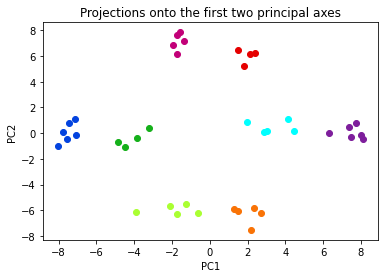

In [3]:
# Perform PCA
def PCA(data, labels):

    # Center our data matrix
    data_centered = data - np.mean(data,axis = 0)

    # Perform singular value decomposition
    u, s, wt = np.linalg.svd(data_centered)
    w = wt.T

    # Calculate the PC scores with the first 2 eigenvectors
    y2 = data_centered @ w[:,:2]

    # Plot the projections onto the first two principal axes
    for i in range(y2.shape[0]):
        plt.scatter(y2[i,0],y2[i,1], c = Color[labels[i]])
    plt.title("Projections onto the first two principal axes")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

# Perform PCA on the small dataset
PCA(small_log, s_labels)

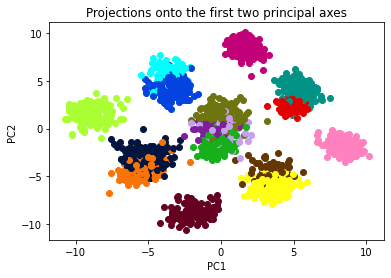

In [4]:
# Perform PCA on the large dataset
PCA(large_log, l_labels)

We can see that there are considerable overlap between clusters that, in reality, are distinct in our scatter plot.  
PCA works well in our previous 2D problem, however, here in Moriaty's dataset, we have much more than 2 PCs with significant variances, PCA's rigid rotation would fundamentally limit our ability to separate clusters of 8 and 16 cell types in our small and large datasets respectively.  
  
Therefore, a nonlinear projection like t-SNE may do better.

# 2. Implement t-SNE
Next, we are going to use t-SNE implementation to visualize Moriarty's smaller data set in two t-SNE dimensions, following the description of the van der Maaten and Hinton (2008) paper.

In [5]:
# Calculate the distance matrix
def calculate_dist(X):
    # calculate the distance between each pair of points in the dataset, storing in a matrix D 
    D = np.zeros((X.shape[0], X.shape[0]))
    for i in range(D.shape[0]):
        for j in range(D.shape[0]):
            if (i==j):
                D[i,j] = 0
            else:
                D[i,j] = np.linalg.norm(X[i]-X[j])
    return D

# Calculate the perplexity difference
def perplexity_diff(sigma_i, D_i, perplexity_true):
    
    # Calculate P_ji
    P_ji = (np.exp(-D_i**2/(2*sigma_i**2)))/(sum(np.exp(-D_i**2/(2*sigma_i**2)))-1)
    P_ji = np.where(D_i == 0, 1, P_ji)

    # calculate the entropy
    H_i = -sum(P_ji*np.log2(P_ji))
    
    # calculate estimated perplexity 
    perplexity_i = 2**H_i
    
    # calculate difference between perplexity_true and estimated
    diff = perplexity_i - perplexity_true
    return diff

# Calculate sigma for each point i
def calculate_sigma(data, perplexity_true):
    D = calculate_dist(data)
    sigma = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        a = 1
        while perplexity_diff(a, D[i], perplexity_true) > 0: # while were not below 0
            a /= 2 # decrease function
        b = 1
        while perplexity_diff(b, D[i], perplexity_true) < 0: # while were not above 0
            b *= 2 # increase function
        sigma[i] = optimize.bisect(perplexity_diff, a, b, args=(D[i], perplexity_true))
    return sigma

sigma = calculate_sigma(small_log, 5)
sigma

array([2.8040328 , 2.70201468, 2.87200524, 2.90997103, 3.00873499,
       2.96471681, 2.90244442, 2.2828542 , 3.12386293, 3.17739473,
       3.24120817, 2.89590576, 2.62283829, 3.13756539, 2.86375709,
       2.60599897, 3.09181874, 2.58115649, 2.79410126, 3.22153449,
       2.74402597, 2.5539275 , 2.90030879, 3.30743463, 3.27779816,
       2.91062925, 2.94449782, 2.58322407, 2.74474151, 2.56562196,
       2.8185743 , 2.79919192, 3.09510125, 2.45558702, 3.43416328,
       2.77194493, 3.01952237, 2.89267478, 2.39289975, 2.98980185])

In [6]:
# Calculate the conditional probability that j is i's neighbor P_j|i
def calculate_conditional(X, sigma):
    D = calculate_dist(X)
    P_ji = np.zeros((D.shape))
    
    for i in range(D.shape[0]):
        num = np.exp(-D[i]**2/(2*sigma[i]**2))
        num[i] = 0 # set all diagonal entries of the conditional matrix to 0
        P_ji[i] = num/np.sum(num)
        
    # Normalize P_ji    
    P_ji = (P_ji+P_ji.T)/(2*D.shape[0])
    return P_ji

# Calculate Q, the probabity distribution in the 2-dimensional space
def calculate_Q(Y):
    D_Y = calculate_dist(Y)
    Q = np.empty((1, Y.shape[0]))
    
    for i in range(D_Y.shape[0]):
        q = (D_Y[i]**2+1)**(-1)
        q[int(np.where(D_Y[i]==0)[0])] = 0
        q = q.reshape((1,D_Y.shape[0]))
        Q = np.concatenate((Q,q),axis=0)
    Q = np.delete(Q, obj=0, axis=0)
    Q = Q/sum(sum(Q))
    return Q   

# Calculate the KL divergence
def KL(Y,P):
    # flatten Y
    Y = np.reshape(Y,(P.shape[0],2))
    # calculate Q
    Q = calculate_Q(Y)
    D_Y = calculate_dist(Y)
    
    # calculate KL divergence
    KL = np.sum(P*(np.log2(P,where=(P!=0)) - np.log2(Q,where=(Q!=0))))
    
    # calculate gradient
    gradient = np.zeros(Y.shape)
    for i in range(gradient.shape[0]):
        vector1 = P[i]-Q[i]
        vector2 = (D_Y[i]**2+1)**(-1)
        for j in range(gradient.shape[1]):
            vector3 = np.array([Y[i,j]-Y[k,j] for k in range(Y.shape[0])])
            gradient[i,j] = 4*sum(vector1*vector2*vector3)
    
    return(KL,gradient.flatten())

# Finally, the t-SNE implementation
def t_SNE(data, perplexity_true):
    # calculate the P
    sigma = calculate_sigma(data, perplexity_true)
    P = calculate_conditional(data, sigma)
    
    # generate some random Y
    Y = np.random.normal(0,1e-4,(data.shape[0],2))
    
    # minimize the KL divergence
    result = optimize.minimize(KL, Y.flatten(), args=(P), jac=True)
    result = np.reshape(result.x, Y.shape)
    return result

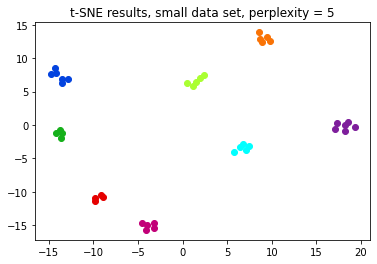

In [12]:
# Perform the t-SNE and visualize the results
tSNE = t_SNE(small_log, 5)
for i in range(tSNE.shape[0]):
    plt.scatter(tSNE[i,0],tSNE[i,1], c = Color[s_labels[i]])
plt.title("t-SNE results, small data set, perplexity = 5")
plt.show()

Here we can see that our t-SNE successfully clusters the eight different neural cell types in the small dataset. Compared with PCA in part1, the points are closer to each other and the clusters are more concentrated in the t-SNE results, indicating that a nonlinear projection works better than the rigid linear one on a high dimension dataset.


## 3. Using the canned t-SNE from scikit

`Scikit-learn` provides a suite of machine learning tools in Python, including `sklearn.manifold.TSNE`.    
  
We could next use `sklearn.manifold.TSNE` to visualize both the small and large Moriarty data sets in two t-SNE dimensions, for four different choices of perplexity: 2, 5, 30, and 100.

In [8]:
# First, for the small dataset
np.random.seed(9)
perplexities = [2,5,30,100]

# Perform t-SNE
Y_s = []
for p in perplexities:
    Y_s.append(TSNE(perplexity=p).fit_transform(small_log))

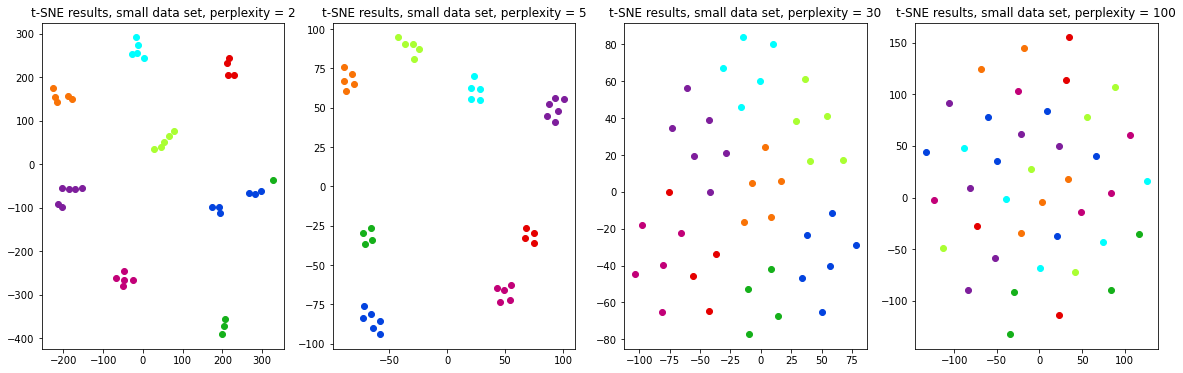

In [9]:
# Plot the result
fig,axs = plt.subplots(1,4,figsize=(20,6))
for i in range(len(perplexities)):
    for j in range(len(small)):
        axs[i].scatter(Y_s[i][j,0], Y_s[i][j,1],c = Color[s_labels[j]%16])
        axs[i].set_title('t-SNE results, small data set, perplexity = {}'.format(perplexities[i]))
plt.show()

In [10]:
# Next, for the large dataset
np.random.seed(9)
perplexities = [2,5,30,100]

# Perform t-SNE
Y_l = []
for p in perplexities:
    Y_l.append(TSNE(perplexity=p).fit_transform(large_log))

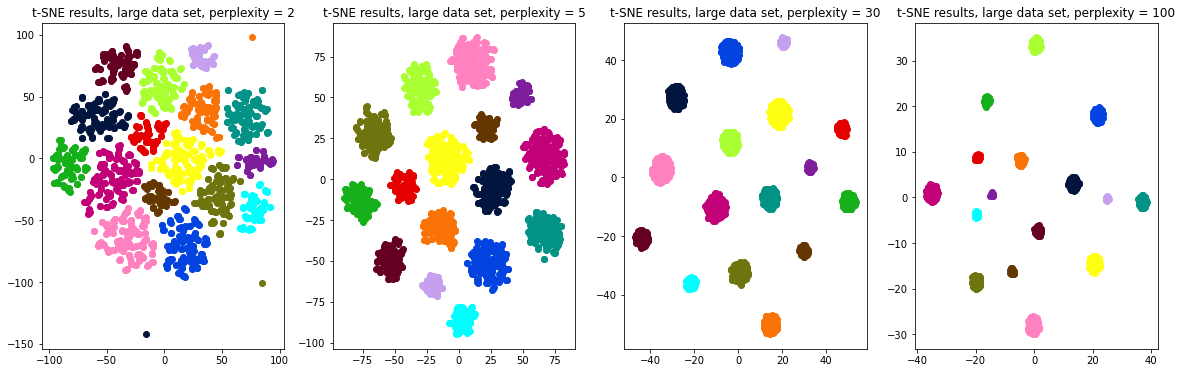

In [11]:
# Plot the result
fig,axs = plt.subplots(1,4,figsize=(20,6))
for i in range(len(perplexities)):
    for j in range(len(large)):
        axs[i].scatter(Y_l[i][j,0], Y_l[i][j,1],c = Color[l_labels[j]%16])
        axs[i].set_title('t-SNE results, large data set, perplexity = {}'.format(perplexities[i]))
plt.show()

Perplexity is basically a guess about the number of close neighbors each point has, and it could tell the t-SNE model how to balance attention between local and global aspects.   
  
Here we can see that as we increase the value, the plot changes drastically. With perplexity 2, local variations dominate; When increasing perplexity to 5, the t-SNE model for small dataset seperate different clusters distinctly; And both 30 and 100 seems to work well for the large dataset; Finally, when increasing the perplexity to 100 for the small dataset, the data points seem to merge together.   
  
In conclusion, since Perplexity is the effective number of possible outcomes for our probability distribution, we should choose the value according to the possible cluster size for better results. 